# Neural network notebook

## Summary
In this notebook the binding energy data from 1712 nuclei obtained using mean-field models and beyond have been used to train neural networks. Deep neural networks (DNN) with different architectures and optimizers have been employed, and the performance of these networks has been discussed for various datasets and learning rates. The ultimate goal of this project is to evaluate the efficiency of neural networks in the calculation of binding energies and to obtain information about their predictions, errors, and the distribution of predictions in the nuclear chart.

In [1]:
import jupyter_black
# black formatter
jupyter_black.load()

In [2]:
import torch

import torch.nn as nn
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

## Import the data and parse it

In [3]:
import glob
import re

csv_files = glob.glob("data/files_min/*.min")

combined_df_min = pd.DataFrame()
ind = ["min HFB", "min PNP", "min PNPAMP"]
combined_df_min.index = ind
difE = []
list_zn = []

for csv_file in csv_files:
    df = pd.read_csv(csv_file, sep=" ", header=None)
    df.columns = ["beta_2", "E HFB", "E PNP", "E PNPAMP"]
    zn = [int(s) for s in re.findall(r"\d+", csv_file)]
    list_zn.append(zn)
    E_hfb = df.iloc[0, 1]
    E_pnpamp = df.iloc[2, 3]
    difE.append(E_pnpamp - E_hfb)

## Used model

In this case, we will use a four layer dense neural network. This neural network uses a ReLU as internal and activation layers. It also uses dropout to avoid overtraining with $p=0.3$ as well as batch normalization. It initializes the weights by using the He and Kaiming initialization ([article](https://arxiv.org/abs/1502.01852)). 

In [4]:
class MyModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MyModel, self).__init__()
        self.dropout = nn.Dropout(p=0.3)
        self.fc1 = nn.Linear(input_dim, 1000)
        self.fc2 = nn.Linear(1000, 750)
        self.fc3 = nn.Linear(750, 600)
        self.fc4 = nn.Linear(600, 800)
        self.fc5 = nn.Linear(800, output_dim)
        self.internal = nn.ReLU()
        self.activation = nn.ReLU()
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        self.batchnorm1 = nn.BatchNorm1d(1000, eps=1e-05, momentum=None)
        self.batchnorm2 = nn.BatchNorm1d(750, eps=1e-05, momentum=None)
        self.batchnorm3 = nn.BatchNorm1d(600, eps=1e-05, momentum=None)
        self.batchnorm4 = nn.BatchNorm1d(800, eps=1e-05, momentum=None)

    def forward(self, x):
        x1 = self.internal(self.fc1(x))
        x1 = self.batchnorm1(x1)
        x1 = self.dropout(x1)
        x2 = self.internal(self.fc2(x1))
        x2 = self.batchnorm2(x2)
        x2 = self.dropout(x2)
        x3 = self.internal(self.fc3(x2))
        x3 = self.batchnorm3(x3)
        x3 = self.dropout(x3)
        x4 = self.internal(self.fc4(x3))
        x4 = self.batchnorm4(x4)
        x4 = self.dropout(x4)
        y = self.activation(self.fc5(x4))
        return y

In [5]:
x = torch.tensor(list_zn)
y = torch.tensor(np.abs(difE))

## Dataloaders

The dataloaders create random samples for the neural nertwork training. This samples can be created with batches, which in this case have been chosen to be batches of size 128. Literature suggest batches of size of powers of 2: 16, 32, 64, 128, 256... The dataloaders also allow the training dataset be of different sizes.

In [6]:
from torch.utils.data import TensorDataset, DataLoader
import torch


def create_dataloaders(x, y, split_ratio, batch_size):
    dataset = TensorDataset(x, y)
    train_size = int(len(dataset) * split_ratio)
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, test_size]
    )
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, drop_last=True
    )
    test_loader = DataLoader(test_dataset, batch_size=test_size, shuffle=False)

    return train_loader, test_loader, train_size

# Training

When training we have to choose an optimizer and a loss function. We chose and MSELoss function (or mean squared error function) due to the problem being continuous and requiring a ReLU activation function. Now we are left to decide which optimizer is best to use in the calculation of this model. We start with the SGD optimizer. 

## SGD

In [7]:
def training_model_SGD(x, y, data_size, learning_rate, batch_size):
    train_loader, test_loader, train_size = create_dataloaders(
        x, y, split_ratio=data_size, batch_size=batch_size
    )
    net = MyModel(2, 1)
    net = net.float()
    criterion = torch.nn.MSELoss(reduction="mean")
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    dloss = 1
    nepoch = 0
    net.train()
    hatY = torch.zeros(train_size, 1)
    n_batches = int(np.floor(train_size / batch_size))
    new_loss = np.zeros(n_batches)
    previous_loss = np.zeros(n_batches)
    print(
        f"training with {n_batches} batches in {train_size} points of data with learning_rate={learning_rate}"
    )
    while dloss > 1e-2 and nepoch < 5000:
        for batch_idx, (x_train, y_train) in enumerate(train_loader):
            x_train = x_train.float()
            y_train = y_train.float()
            hatY = net.forward(x_train)
            optimizer.zero_grad()
            train_loss = criterion(hatY, y_train)
            train_loss.backward()
            optimizer.step()
            # x_train.append(x_train)
            # y_train.append(y_train)
            if nepoch % 50 == 0:
                new_loss[batch_idx] = train_loss.item()
                print(
                    f"The loss function for {nepoch} is {new_loss} and batch numb={batch_idx}"
                )
                if batch_idx == n_batches - 1:
                    dloss = np.abs(np.mean(new_loss - previous_loss))
                    print(f"current diff{dloss}")
                    previous_loss = new_loss
                    new_loss = np.zeros(n_batches)
        nepoch += 1
    if dloss < 1e-2:
        has_finished = True
    else:
        has_finished = False
    all_x_train = torch.Tensor()
    all_y_train = torch.Tensor()
    for x_train, y_train in train_loader:
        all_x_train = torch.cat((all_x_train, x_train), 0)
        all_y_train = torch.cat((all_y_train, y_train), 0)
    hatY = net.forward(all_x_train)
    with torch.no_grad():
        net.eval()
        for x_test, y_test in test_loader:
            x_test = x_test.float()
            y_test = y_test.float()
            hatY_pred = net.forward(x_test)
            hatY_detach = hatY_pred.detach()
            test_loss = criterion(hatY_detach, y_test)

    return (
        test_loss,
        train_loss,
        nepoch,
        hatY,
        hatY_pred,
        all_x_train,
        x_test,
        all_y_train,
        y_test,
        has_finished,
    )

### Grid search

The next cell performs gridsearch to determine which parameters of learning rate and training size are the best for the problem. (It is quite time consuming and you should not run it on slow computers)

In [8]:
#grid search
learning_rates=np.logspace(-5,-1,5)
data_sizes=np.array([0.3,0.4,0.5,0.6,0.7,0.8])
test_loss=np.zeros((len(data_sizes), len(learning_rates)))
train_loss= np.zeros_like(test_loss)
nepochs=np.zeros_like(test_loss)
fontsize=16
for a_iter, data_size in enumerate(data_sizes):
    for b_iter, learning_rate in enumerate(learning_rates):
        total_loss, dloss, loss, i, hatY, hatY_pred,  x_train, x_test, y_train, y_test=training_model_SGD(data_size=data_size, learning_rate=learning_rate, batch_size=4)
        test_loss[a_iter,b_iter]=total_loss.item()
        train_loss[a_iter, b_iter]=loss.item()
        nepochs[a_iter,b_iter]=i



c:\Users\pablo\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\pablo\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1584])) that is different to the input size (torch.Size([1584, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\pablo\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([42])) that is different to the input size (torch.Size([42, 1])). This will likely lead to inco

In [8]:
def plot_data(x, y, data, title):

    # plot results
    fontsize = 12

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(data, interpolation="nearest", vmin=0, vmax=2, cmap="cool")

    cbar = fig.colorbar(cax)
    cbar.ax.set_ylabel("loss", rotation=90, fontsize=fontsize)
    cbar.set_ticks([0, 0.4, 0.8, 1.2, 1.6, 2])
    cbar.set_ticklabels(["0", "0.4", "0.8", "1.2", "1.6", "2"])

    # put text on matrix elements
    for i, x_val in enumerate(np.arange(len(x))):
        for j, y_val in enumerate(np.arange(len(y))):
            if data[j, i] > 1000:
                c = "{0:.1e}".format(data[j, i])
            else:
                c = "{0:.2f}".format(data[j, i])
            ax.text(x_val, y_val, c, va="center", ha="center")

    # convert axis vaues to to string labels
    x = [str(i) for i in x]
    y = [str(i) for i in y * 100]

    ax.set_xticklabels([""] + x)
    ax.set_yticklabels([""] + y)

    ax.set_xlabel("Tasa de aprendizaje", fontsize=fontsize)
    ax.set_ylabel("Tamaño de datos de entrenamiento (%)", fontsize=fontsize)
    ax.set_title(title)

    plt.tight_layout()

    plt.show()

C:\Users\pablo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\pablo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator


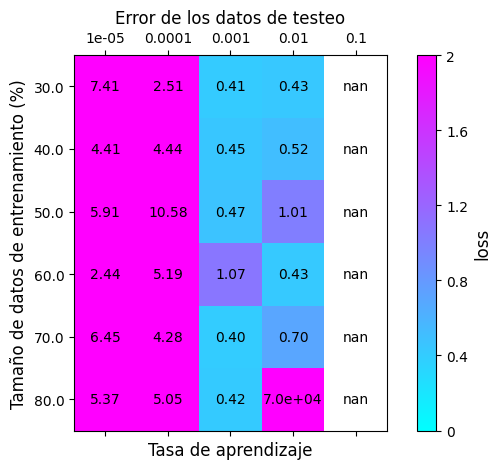

In [10]:
plot_data(learning_rates, data_sizes, test_loss, "Error de los datos de testeo")

C:\Users\pablo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\pablo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator


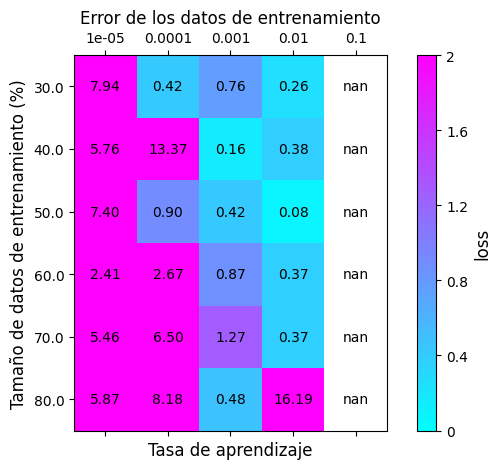

In [11]:
plot_data(learning_rates, data_sizes, train_loss, "Error de los datos de entrenamiento")

In [12]:
def plot_data_epochs(x,y,data, title: str):

    # plot results
    fontsize=12


    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(data, interpolation='nearest', vmin=0, vmax=4000, cmap="cool")
    
    cbar=fig.colorbar(cax)
    cbar.ax.set_ylabel('número iteraciones',rotation=90,fontsize=fontsize)
    cbar.set_ticks([0,800,1600,2400,3200,4000])
    cbar.set_ticklabels(['0','800','1600','2400','3200','4000'])

    # put text on matrix elements
    for i, x_val in enumerate(np.arange(len(x))):
        for j, y_val in enumerate(np.arange(len(y))):
            c = "{0:.01f}".format( data[j,i])  
            ax.text(x_val, y_val, c, va='center', ha='center')

    # convert axis vaues to to string labels
    x=[str(i) for i in x]
    y=[str(i) for i in y*100]


    ax.set_xticklabels(['']+x)
    ax.set_yticklabels([""]+y)

    ax.set_xlabel('Tasa de aprendizaje',fontsize=fontsize)
    ax.set_ylabel("Tamaño de datos de entrenamiento (%)",fontsize=fontsize)
    ax.set_title(title)

    plt.tight_layout()

    plt.show()
    

C:\Users\pablo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\pablo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator


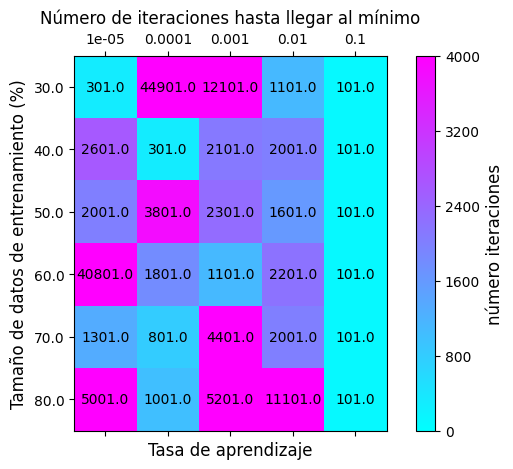

In [13]:
plot_data_epochs(learning_rates, data_sizes, nepochs, "Número de iteraciones hasta llegar al mínimo")

In [14]:
# Create a DataFrame from the NumPy array
df = pd.DataFrame(test_loss, 
                  columns=['1e-05', '0.0001', '0.001', '0.01', '0.1'],  # Example learning rates
                  index=[0.3, 0.4, 0.5, 0.6, 0.7, 0.8])  # Example data sizes

df.to_csv('test_loss.csv')
df = pd.DataFrame(train_loss, 
                  columns=['1e-05', '0.0001', '0.001', '0.01', '0.1'],  # Example learning rates
                  index=[0.3, 0.4, 0.5, 0.6, 0.7, 0.8])  # Example data sizes

df.to_csv('train_loss.csv')
df = pd.DataFrame(nepochs, 
                  columns=['1e-05', '0.0001', '0.001', '0.01', '0.1'],  # Example learning rates
                  index=[0.3, 0.4, 0.5, 0.6, 0.7, 0.8])  # Example data sizes

df.to_csv('nepochs.csv')


### Plotting the nucleii table
It will be intereseting to the MSE obtained during the training of each nuclei. This way we could know where the neural network makes better predictions and where it lands short

In [9]:
learning_rate = 1e-2
split_ratio = 0.3
(
    test_loss,
    train_loss,
    nepoch,
    hatY,
    hatY_pred,
    all_x_train,
    x_test,
    all_y_train,
    y_test,
    has_finished,
) = training_model_SGD(
    x=x, y=y, data_size=split_ratio, learning_rate=learning_rate, batch_size=128
)

training with 4 batches in 513 points of data with learning_rate=0.01
The loss function for 0 is [12.67739391  0.          0.          0.        ] and batch numb=0
The loss function for 0 is [12.67739391 11.60006523  0.          0.        ] and batch numb=1
The loss function for 0 is [12.67739391 11.60006523 10.36821365  0.        ] and batch numb=2
The loss function for 0 is [12.67739391 11.60006523 10.36821365 14.76272774] and batch numb=3
current diff12.352100133895874


/home/pablo/miniconda3/envs/myenv/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


The loss function for 50 is [15.21291542  0.          0.          0.        ] and batch numb=0
The loss function for 50 is [15.21291542 14.5791502   0.          0.        ] and batch numb=1
The loss function for 50 is [15.21291542 14.5791502  14.61493111  0.        ] and batch numb=2
The loss function for 50 is [15.21291542 14.5791502  14.61493111 14.25461769] and batch numb=3
current diff2.3133034706115723
The loss function for 100 is [14.86252499  0.          0.          0.        ] and batch numb=0
The loss function for 100 is [14.86252499 14.6162262   0.          0.        ] and batch numb=1
The loss function for 100 is [14.86252499 14.6162262  14.4349041   0.        ] and batch numb=2
The loss function for 100 is [14.86252499 14.6162262  14.4349041  14.68039513] and batch numb=3
current diff0.016891002655029297
The loss function for 150 is [15.38221073  0.          0.          0.        ] and batch numb=0
The loss function for 150 is [15.38221073 14.60574055  0.          0.       

/home/pablo/miniconda3/envs/myenv/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1199])) that is different to the input size (torch.Size([1199, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [16]:
def marker_plot(x_train, y_train, difE_train, x_test, y_test, difE_test, optimizer):
    plt.figure(figsize=(12, 9))
    absolute_difE_test = np.abs(np.add(difE_test, -y_test))
    absolute_difE_train = np.abs(difE_train - y_train)
    absolute_dif = [absolute_difE_test.max(), absolute_difE_train.max()]
    max_value_painted = max(absolute_dif)

    sc1 = plt.scatter(
        x_test[:, 1],
        x_test[:, 0],
        c=difE_test - y_test,
        marker="D",
        label="Test data",
        vmax=max_value_painted - 2,
        vmin=-max_value_painted + 2,
        cmap="RdBu",
        s=20,
    )
    sc2 = plt.scatter(
        x_train[:, 1],
        x_train[:, 0],
        c=difE_train - y_train,
        marker="*",
        label="Training data",
        vmax=max_value_painted - 1,
        vmin=-max_value_painted + 1,
        cmap="RdBu",
        s=20,
    )
    plt.xlabel("N", fontsize=16)
    plt.xticks([8, 20, 28, 50, 82, 126, 198], fontsize=16)
    plt.yticks([8, 20, 28, 50, 82, 110], fontsize=16)
    for tick in [8, 20, 28, 50, 82]:
        plt.axvline(x=tick, color="gray", linestyle="--", linewidth=0.5)
        plt.axhline(y=tick, color="gray", linestyle="--", linewidth=0.5)
    plt.axvline(x=126, color="gray", linestyle="--", linewidth=0.5)
    plt.axvline(x=198, color="gray", linestyle="--", linewidth=0.5)
    plt.axhline(y=110, color="gray", linestyle="--", linewidth=0.5)
    plt.ylabel("Z", fontsize=16)
    plt.title(
        f"Neural network using {optimizer} lr={learning_rate} and using {split_ratio * 100}% of nuclei"
    )
    legend_elements = [
        plt.Line2D(
            [0],
            [0],
            marker="D",
            color="w",
            markerfacecolor="black",
            label="Test data",
            markersize=8,
        ),
        plt.Line2D(
            [0],
            [0],
            marker="*",
            color="w",
            markerfacecolor="black",
            label="Training data",
            markersize=15,
        ),
    ]
    plt.legend(handles=legend_elements)
    cbar1 = plt.colorbar(
        sc1, ax=plt.gca(), label="Difference between prediction and real energies"
    )
    cbar1.set_label("Relative error (MeV)", fontsize=16)

    plt.show()

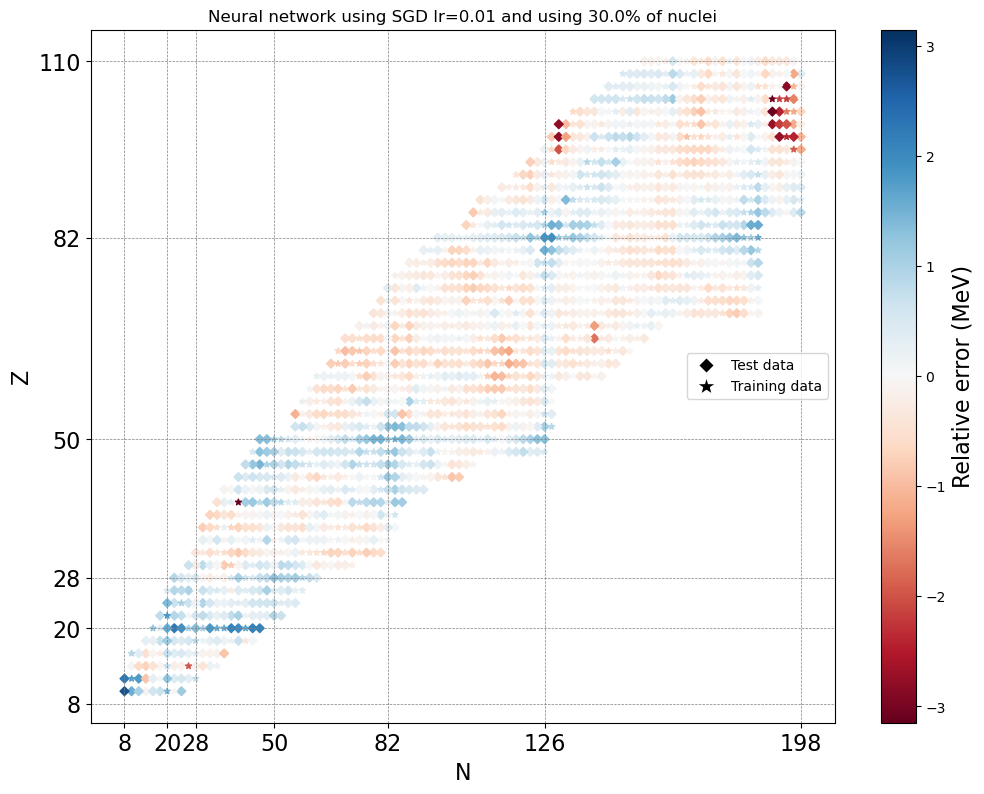

In [17]:
marker_plot(
    x_train=all_x_train,
    y_train=all_y_train,
    difE_train=hatY.detach().flatten(),
    x_test=x_test,
    y_test=y_test,
    difE_test=hatY_pred.detach().flatten(),
    optimizer="SGD",
)

## Adam optimizer
We should now consider if there are other ways of obtaining better results by changing the optimizer. In this case we will use the Adam optimizer which is a second order optimizer ([Article](https://arxiv.org/abs/1412.6980)). 

In [14]:
def training_model_Adam(x, y, data_size, learning_rate, batch_size):
    train_loader, test_loader, train_size = create_dataloaders(
        x, y, split_ratio=data_size, batch_size=batch_size
    )
    net_slice = MyModel(2, 1)
    net_slice = net_slice.float()
    criterion = torch.nn.MSELoss(reduction="mean")
    optimizer = torch.optim.Adam(net_slice.parameters(), lr=learning_rate)
    dloss = 1
    i = 0
    nepoch = 0
    net_slice.train()
    hatY = torch.zeros(train_size, 1)
    n_batches = int(np.floor(train_size / batch_size))
    new_loss = np.zeros(n_batches)
    previous_loss = np.zeros(n_batches)
    print(
        f"training with {n_batches} batches in {train_size} points of data with learning_rate={learning_rate}"
    )
    while dloss > 1e-2 and nepoch < 5000:
        for batch_idx, (x_train_slice, y_train_slice) in enumerate(train_loader):
            x_train_slice = x_train_slice.float()
            y_train_slice = y_train_slice.float()
            hatY_slice = net_slice.forward(x_train_slice)
            optimizer.zero_grad()
            loss_slice = criterion(hatY_slice, y_train_slice)
            loss_slice.backward()
            optimizer.step()
            # x_train.append(x_train_slice)
            # y_train.append(y_train_slice)
            if nepoch % 50 == 0:
                new_loss[batch_idx] = loss_slice.item()
                print(
                    f"The loss function for {nepoch} is {new_loss} and batch numb={batch_idx}"
                )
                if batch_idx == n_batches - 1:
                    dloss = np.abs(np.mean(new_loss - previous_loss))
                    print(f"current diff{dloss}")
                    previous_loss = new_loss
                    new_loss = np.zeros(n_batches)
        nepoch += 1
    if dloss < 1e-2:
        has_finished = True
    else:
        has_finished = False
    all_x_train = torch.Tensor()
    all_y_train = torch.Tensor()
    for x_train, y_train in train_loader:
        all_x_train = torch.cat((all_x_train, x_train), 0)
        all_y_train = torch.cat((all_y_train, y_train), 0)
    hatY = net_slice.forward(all_x_train)
    # elapsed_time = time.time() - start_time
    with torch.no_grad():
        net_slice.eval()
        for x_test, y_test in test_loader:
            x_test = x_test.float()
            y_test = y_test.float()
            hatY_pred = net_slice.forward(x_test)
            hatY_detach = hatY_pred.detach()
            test_loss = criterion(hatY_detach, y_test)

    return (
        test_loss,
        loss_slice,
        nepoch,
        hatY,
        hatY_pred,
        all_x_train,
        x_test,
        all_y_train,
        y_test,
        has_finished,
    )

In [18]:
learning_rate = 1e-2
split_ratio = 0.3
(
    test_loss,
    train_loss,
    nepoch,
    hatY,
    hatY_pred,
    all_x_train,
    x_test,
    all_y_train,
    y_test,
    has_finished,
) = training_model_Adam(
    x=x, y=y, data_size=split_ratio, learning_rate=learning_rate, batch_size=128
)

training with 4 batches in 513 points of data with learning_rate=0.01
The loss function for 0 is [12.49891567  0.          0.          0.        ] and batch numb=0
The loss function for 0 is [12.49891567 11.92458725  0.          0.        ] and batch numb=1
The loss function for 0 is [12.49891567 11.92458725 16.82761002  0.        ] and batch numb=2
The loss function for 0 is [12.49891567 11.92458725 16.82761002  8.8964386 ] and batch numb=3
current diff12.536887884140015


/home/pablo/miniconda3/envs/myenv/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


The loss function for 50 is [0.66500449 0.         0.         0.        ] and batch numb=0
The loss function for 50 is [0.66500449 0.67540908 0.         0.        ] and batch numb=1
The loss function for 50 is [0.66500449 0.67540908 0.53953087 0.        ] and batch numb=2
The loss function for 50 is [0.66500449 0.67540908 0.53953087 0.53297627] and batch numb=3
current diff11.933657705783844
The loss function for 100 is [0.48598936 0.         0.         0.        ] and batch numb=0
The loss function for 100 is [0.48598936 0.55132383 0.         0.        ] and batch numb=1
The loss function for 100 is [0.48598936 0.55132383 0.36629987 0.        ] and batch numb=2
The loss function for 100 is [0.48598936 0.55132383 0.36629987 0.4266462 ] and batch numb=3
current diff0.14566536247730255
The loss function for 150 is [0.44128177 0.         0.         0.        ] and batch numb=0
The loss function for 150 is [0.44128177 0.30061564 0.         0.        ] and batch numb=1
The loss function for

/home/pablo/miniconda3/envs/myenv/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1199])) that is different to the input size (torch.Size([1199, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


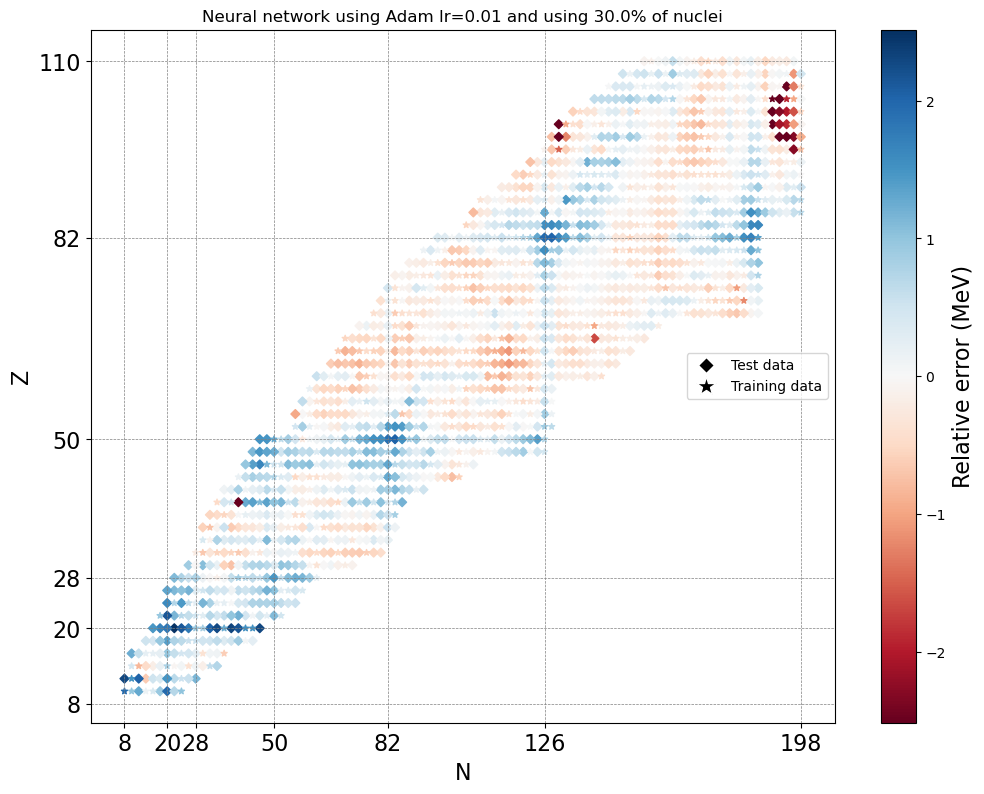

In [19]:
marker_plot(
    x_train=all_x_train,
    y_train=all_y_train,
    difE_train=hatY.detach().flatten(),
    x_test=x_test,
    y_test=y_test,
    difE_test=hatY_pred.detach().flatten(),
    optimizer="Adam",
)

### Gridsearch
Again it is interesting to find what are the best values for the hyperparameters. Performing a gridsearch would be ideal to obtain that

In [ ]:
#grid search
learning_rates=np.logspace(-5,-1,5)
data_sizes=np.array([0.3,0.4,0.5,0.6,0.7,0.8])
test_loss=np.zeros((len(data_sizes), len(learning_rates)))
train_loss= np.zeros_like(test_loss)
nepochs=np.zeros_like(test_loss)
fontsize=16
for a_iter, data_size in enumerate(data_sizes):
    for b_iter, learning_rate in enumerate(learning_rates):
        total_loss, dloss, loss, i, hatY, hatY_pred,  x_train, x_test, y_train, y_test=training_model_Adam(data_size=data_size, learning_rate=learning_rate, batch_size=4)
        test_loss[a_iter,b_iter]=total_loss.item()
        train_loss[a_iter, b_iter]=loss.item()
        nepochs[a_iter,b_iter]=i

